In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt

plt.style.use('seaborn-whitegrid')

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [34]:
from lightgbm import LGBMRegressor

In [2]:
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder

from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_extraction.text import CountVectorizer

In [3]:
!git clone https://github.com/BigcontestParrot2020/csv.git

Cloning into 'csv'...
remote: Enumerating objects: 9, done.
remote: Counting objects: 100% (9/9), done.
remote: Compressing objects: 100% (7/7), done.
remote: Total 9 (delta 2), reused 0 (delta 0), pack-reused 0
Unpacking objects: 100% (9/9), done.


In [16]:
os.chdir('csv/')

In [4]:
!apt install fonts-nanum

import matplotlib as mpl
import matplotlib.font_manager as fm

fontpath = '/usr/share/fonts/truetype/nanum/NanumBarunGothic.ttf'
font = fm.FontProperties(fname=fontpath, size=9)
plt.rc('font', family='NanumBarunGothic') 
mpl.font_manager._rebuild()

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following NEW packages will be installed:
  fonts-nanum
0 upgraded, 1 newly installed, 0 to remove and 11 not upgraded.
Need to get 9,604 kB of archives.
After this operation, 29.5 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic/universe amd64 fonts-nanum all 20170925-1 [9,604 kB]
Fetched 9,604 kB in 1s (8,745 kB/s)
Selecting previously unselected package fonts-nanum.
(Reading database ... 144676 files and directories currently installed.)
Preparing to unpack .../fonts-nanum_20170925-1_all.deb ...
Unpacking fonts-nanum (20170925-1) ...
Setting up fonts-nanum (20170925-1) ...
Processing triggers for fontconfig (2.12.6-0ubuntu2) ...


In [17]:
data = pd.read_csv('0918_ver.csv', encoding = 'utf-8', index_col = 0).iloc[:,1:]
data = data.dropna()

del data['마더코드']
del data['상품코드']
del data['평균단가']
del data['년']
del data['분']
del data['소비층']

In [18]:
data['취급액_로그'] = np.log(data.취급액)
data = data.drop(columns = ['취급액'])

In [38]:
data.head()

,상품명,상품군,판매단가,월,일,시,요일,휴일,프라임,First,Middle,Last,취급액_로그,세일,결제유형,성별,원플원
방송일시,,,,,,,,,,,,,,,,,
2019-01-01 06:00:00,테이트 셀린니트,의류,39900,1,1,6,Tuesday,2,4,1.0,0.0,0.0,14.556972,0,0,1,0
2019-01-01 06:00:00,테이트 셀린니트,의류,39900,1,1,6,Tuesday,2,4,1.0,0.0,0.0,15.290502,0,0,2,0
2019-01-01 06:20:00,테이트 셀린니트,의류,39900,1,1,6,Tuesday,2,4,0.0,1.0,0.0,14.997851,0,0,1,0
2019-01-01 06:20:00,테이트 셀린니트,의류,39900,1,1,6,Tuesday,2,4,0.0,1.0,0.0,15.754971,0,0,2,0
2019-01-01 06:40:00,테이트 셀린니트,의류,39900,1,1,6,Tuesday,2,4,0.0,0.0,1.0,15.713430,0,0,1,0


## Define Functions

In [7]:
import re

def max_words(goods_kind):
    words = ' '.join(list(data[data.상품군 == goods_kind].상품명.values))

    words = re.split(r'[+ ]', words)
    words = list(filter(lambda x: x != '', words))
    word_count = {}
    for word in set(words):
        count = words.count(word)
        word_count.update({word:count})
        
    return word_count

In [8]:
def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [9]:
def train_df(group_name, max_features):
    group_df = data[data.상품군 == group_name]

    # Apply CountVectorizer with preprocessed 상품명
    words = ' '.join(list(group_df.상품명.dropna().values))
    words = re.split(r'[()+ ]', words)
    words = list(filter(lambda x: x != '', words))

    vect = CountVectorizer(max_features = max_features)
    vect.fit(words)

    # merge base dataframe with word-embedding dataframe
    df = pd.DataFrame(np.stack(group_df.상품명.map(lambda x: vect.transform(x.split()).toarray().sum(axis=0)).values),
                      columns=vect.get_feature_names(),
                      index = group_df.index)
    df = pd.concat([group_df, df], axis=1)
    df = df.drop(columns = ['상품명','상품군'])

    # LabelEncoder
    LE_요일 = LabelEncoder()
    df.요일 = LE_요일.fit_transform(df.요일)

    return df

In [10]:
mmscaler = MinMaxScaler()

def LGBM_train(df):
    month = list(set(df.월))

    raw_x = df.drop(columns=['취급액_로그'])
    raw_y = df[['취급액_로그','월']]

    cv_test = {}
    cv_predict = {}
    cv_scores = {}
    cv_models = {}

    for m in month:

        try:
            test_x = raw_x[raw_x.월 == m].drop(columns = ['월'])
            test_y = raw_y[raw_y.월 == m].취급액_로그
            train_x = raw_x.drop(index = test_x.index, columns = ['월'])
            train_y = raw_y.drop(index = test_y.index).취급액_로그
        
            test_x = mmscaler.fit_transform(test_x)
            train_x = mmscaler.fit_transform(train_x)

            train_y = train_y.to_numpy().reshape(-1)
            test_y = test_y.to_numpy().reshape(-1)
            
            lgb = LGBMRegressor(n_estimators = 5000, num_leaves = 500)
            lgb.fit(train_x, train_y,
                    early_stopping_rounds=1000,
                    eval_set = [(test_x, test_y)],
                    eval_metric = 'mape',
                    verbose = False)
            predict_test = lgb.predict(test_x)

            test_y = np.exp(test_y)
            predict_test = np.exp(predict_test)

            cv_test.update({m:test_y})
            cv_predict.update({m: predict_test})

            mape = mean_absolute_percentage_error(test_y, predict_test)
            print(f'{m}월 MAPE:', mape)

            cv_scores.update({m:mape})
            cv_models.update({m:lgb})
      
        except ValueError:
            print(f'{m}월 MAPE: No Value')
            cv_scores.update({m:'no value'})
            cv_models.update({m:'no value'})

    return cv_scores, cv_models, cv_test, cv_predict

In [11]:
def plot_result(test_dict, predict_dict, scores_dict):
    fig,  ax = plt.subplots(2,6, figsize = (15, 5))
    for i in range(12):
        x = i//6
        y = i%6
        ax[x, y].plot(test_dict[i+1], predict_dict[i+1], linestyle = '', marker = 'o')
        ax[x, y].plot(test_dict[i+1], test_dict[i+1], color = 'r')
        ax[x, y].set_title(f'{i+1}: MAPE {round(scores_dict[i+1],2)}')

## Preprocessing

In [19]:
# 세일 문구
data['세일'] = data.상품명.map(lambda x: 1 if '세일' in x else 0)
data.상품명 = data.상품명.str.replace('세일', '', regex = False)

In [20]:
## 일시불 : 0
## 무이자 : 1


data.상품명 = data.상품명.str.replace('(무)', '무이자', regex = False)
data.상품명 = data.상품명.str.replace('무)', '무이자', regex = False)
data.상품명 = data.상품명.str.replace('무이자', ' 무이자 ', regex = False)
data.상품명 = data.상품명.str.replace('(일)', '일시불', regex = False)
data.상품명 = data.상품명.str.replace('일)', '일시불', regex = False)
data.상품명 = data.상품명.str.replace('일시불', ' 일시불 ', regex = False)

def type(x):
    if '일시불' in x:
        return 1
    if '무이자' in x:
        return 2
    else:
        return 0

data['결제유형'] = data.상품명.map(lambda x: type(x))

data.상품명 = data.상품명.str.replace('무이자', '', regex = False)
data.상품명 = data.상품명.str.replace('일시불', '', regex = False)

In [21]:
# 괄호
data.상품명 = data.상품명.str.replace('[', ' ', regex = False)
data.상품명 = data.상품명.str.replace(']', ' ', regex = False)
data.상품명 = data.상품명.str.replace('(', ' ', regex = False)
data.상품명 = data.상품명.str.replace(')', ' ', regex = False)

In [22]:
## 남성 : 1
## 여성 : 2

data.상품명 = data.상품명.str.replace('남성용', '남성', regex = False)
data.상품명 = data.상품명.str.replace('남성', ' 남성 ', regex = False)
data.상품명 = data.상품명.str.replace('여성용', '여성', regex = False)
data.상품명 = data.상품명.str.replace('여성', ' 여성 ', regex = False)

def sex(x):
    if '남성' in x:
        return 1
    if '여성' in x:
        return 2
    else:
        return 0

data['성별'] = data.상품명.map(lambda x: sex(x))

data.상품명 = data.상품명.str.replace('남성', '', regex = False)
data.상품명 = data.상품명.str.replace('여성', '', regex = False)

In [23]:
# 연도
data.상품명 = data.상품명.str.replace('2018년', '')
data.상품명 = data.상품명.str.replace('2018', '')
data.상품명 = data.상품명.str.replace('2019년', '')
data.상품명 = data.상품명.str.replace('2019', '')
data.상품명 = data.상품명.str.replace('19년', '')
data.상품명 = data.상품명.str.replace('19', '')

In [24]:
data.상품명 = data.상품명.str.replace(r'\d+[월]', '',)
data.상품명 = data.상품명.str.replace(r'\d+[차]', '',)
data.상품명 = data.상품명.str.replace(r'[시][즌]\d+', '',)
data.상품명 = data.상품명.str.replace(r'[시][즌] \d+', '',)

data.상품명 = data.상품명.str.replace(r'\d+[.]\d+[k][g]', '',)
data.상품명 = data.상품명.str.replace(r'\d+[k][g]', '',)
data.상품명 = data.상품명.str.replace(r'\d+[.]\d+[g]', '',)
data.상품명 = data.상품명.str.replace(r'\d+[g]', '',)
data.상품명 = data.상품명.str.replace(r'\d+[.]\d+[L]', '',)
data.상품명 = data.상품명.str.replace(r'\d+[L]', '',)
data.상품명 = data.상품명.str.replace(r'\d+[.]\d+[리][터]', '',)
data.상품명 = data.상품명.str.replace(r'\d+[리][터]', '',)
data.상품명 = data.상품명.str.replace(r'\d+[.]\d+[m]', '',)
data.상품명 = data.상품명.str.replace(r'\d+[m]', '',)

data.상품명 = data.상품명.str.replace(r'\d+[팩]', '',)
data.상품명 = data.상품명.str.replace(r'\d+[박][스]', '',)
data.상품명 = data.상품명.str.replace(r'\d+[미]', '')
data.상품명 = data.상품명.str.replace(r'\d+[개]', '')
data.상품명 = data.상품명.str.replace(r'\d+[포]', '')
data.상품명 = data.상품명.str.replace(r'\d+[마][리]', '')

In [25]:
data.상품명 = data.상품명.str.replace(r'\d+[인][용]', '',)
data.상품명 = data.상품명.str.replace(r'\d+[종]', '',)

In [26]:
data['원플원'] = data.상품명.str.contains('1+1', regex = False)
data['원플원'] = data.원플원.map(lambda x: 1 if x == True else 0)
data.상품명 = data.상품명.str.replace('1+1', '', regex = False)

In [27]:
#data['종'] = data.상품명.str.extract(r'(\d+)[종]').fillna(0)
# data['종'] = data.종.map(lambda x: int(x) if x != 0 else 0)


# data['세트'] = data.상품명.str.extract(r'(\d+)[세트]').fillna(0)
# data['세트'] = data.세트.map(lambda x: int(x) if x != 0 else 0)

# data.상품명 = data.상품명.str.replace(r'\d+[세][트]', '',)

# data['n종세트'] = data.종 +data.세트

In [28]:
## 에디션
data.상품명 = data.상품명.str.replace('블랙 에디션', '')
data.상품명 = data.상품명.str.replace('에디션', '')

## 초특가
data.상품명 = data.상품명.str.replace('초특가', '') #?

# 상품명 전처리

## 주방

In [29]:
data.상품명 = data.상품명.str.replace('쿠첸', ' 쿠첸 ')
data.상품명 = data.상품명.str.replace('쿠쿠', ' 쿠쿠 ')

# 쿠쿠전기밥솥
data.상품명 = data.상품명.str.replace('도냄', '', regex = False)
data.상품명 = data.상품명.str.replace('CRP-QS107FG/FS', '', regex = False)
data.상품명 = data.상품명.str.replace('CRP-107FG/FS', '', regex = False)
data.상품명 = data.상품명.str.replace('QS', '', regex = False) 
data.상품명 = data.상품명.str.replace('블랙스톤', '', regex = False) 

# 쿠첸 압력밥솥
data.상품명 = data.상품명.str.replace('풀스텐', '', regex = False)
data.상품명 = data.상품명.str.replace('A1', '', regex = False)
data.상품명 = data.상품명.str.replace(' 쿠 ', '', regex = False)
data.상품명 = data.상품명.str.replace('신제품', '', regex = False)

# 린나이 가스레인지
data.상품명 = data.상품명.str.replace('자동불꽃조절', '')
data.상품명 = data.상품명.str.replace('간편쿡', '')
data.상품명 = data.상품명.str.replace('2구', '')
data.상품명 = data.상품명.str.replace('3구', '')

# 에코라믹
data.상품명 = data.상품명.str.replace('냄비세트', ' 냄비 세트')
data.상품명 = data.상품명.str.replace('프라이팬세트', ' 프라이팬 세트')
data.상품명 = data.상품명.str.replace('통주물', ' ')
data.상품명 = data.상품명.str.replace('스톤', ' ')

# 후라이팬
data.상품명 = data.상품명.str.replace('후라이팬', ' 프라이팬 ')

# 에어프라이어
data.상품명 = data.상품명.str.replace('대용량', '')
data.상품명 = data.상품명.str.replace('디지털', '')
data.상품명 = data.상품명.str.replace('듀얼쿡', '')


data.상품명 = data.상품명.str.replace('가스와이드그릴레인지', '가스와이드그릴')
data.상품명 = data.상품명.str.replace('스텐큐브', '')
data.상품명 = data.상품명.str.replace('멀티쿡', '멀티쿠커')
data.상품명 = data.상품명.str.replace('팬지', '')

# 도마
data.상품명 = data.상품명.str.replace('도마', ' 도마 ')

data.상품명 = data.상품명.str.replace('대용량', '')

# 재질
data.상품명 = data.상품명.str.replace('스텐', ' 스텐 ')
data.상품명 = data.상품명.str.replace('유리', ' 유리 ')

data.상품명 = data.상품명.str.replace('밀폐용기', ' 밀폐용기')
data.상품명 = data.상품명.str.replace('플랫타입', '')

data.상품명 = data.상품명.str.replace('멀티', '')

data.상품명 = data.상품명.str.replace('만능', '')

def kitchen(x):
    if x.상품군 == '주방':
        x.상품명 = x.상품명.replace('옛', '')
        x.상품명 = x.상품명.replace('멀티', '')
        x.상품명 = x.상품명.replace('크로커다일', '')
    else:
        x.상품명 = x.상품명
    return x

data = data.apply(lambda x: kitchen(x), axis = 1)

data.상품명 = data.상품명.str.replace(' +', ' ')
data.상품명 = data.상품명.str.lstrip()
data.상품명 = data.상품명.str.rstrip()

In [30]:
set(data[data.상품명.str.contains('플랫')].상품명)

{'아가타 골든 마스터 펌프스+플랫슈즈', '아가타 올인원 앵클부츠+플랫슈즈', '아가타 컬러풀 앵클부츠+플랫슈즈'}

In [31]:
word_count = max_words('주방')
max_words_count = sorted(word_count.items(), key = lambda x: x[1], reverse = True)
max_words_count[:40]

[('쿠쿠', 1630),
 ('전기밥솥', 1620),
 ('쿠첸', 1318),
 ('압력밥솥', 1300),
 ('세트', 800),
 ('스텐', 618),
 ('린나이', 441),
 ('가스레인지', 441),
 ('분쇄믹서기', 401),
 ('한일', 401),
 ('가스와이드그릴', 390),
 ('올리고', 390),
 ('프라이팬', 389),
 ('프리미엄형', 385),
 ('냄비', 364),
 ('에어프라이어', 302),
 ('에코라믹', 288),
 ('파뷔에', 235),
 ('매직쉐프', 222),
 ('IH', 206),
 ('에지리', 168),
 ('키친플라워', 141),
 ('도마', 135),
 ('쿠커', 128),
 ('클란츠', 122),
 ('대형', 120),
 ('락앤락', 120),
 ('전자레인지', 120),
 ('항균', 115),
 ('해피콜', 114),
 ('아이넥스', 80),
 ('유로오븐글라스', 78),
 ('모즈', 69),
 ('밀폐용기', 67),
 ('진공', 63),
 ('키친아트', 60),
 ('행주티슈', 60),
 ('가마솥', 57),
 ('싱크선반', 56),
 ('올', 56)]

In [251]:
# data_주방 = data[data.상품군 == '주방']
# data_주방.index = pd.to_datetime(data_주방.index)

# plot_df = data_주방.resample('30T').count()['취급액'].to_frame()
# plot_df['요일'] = plot_df.index.strftime('%A')
# plot_df['시간'] = plot_df.index.strftime('%H:%M')
# plot_df['취급액'] = plot_df.취급액.map(lambda x: np.NaN if x == 0 else x)

# plot_df = plot_df.groupby(['요일','시간']).count()

# weekday =  list(set(plot_df.index.get_level_values(0)))
# fig,  ax = plt.subplots(3,3, figsize = (15, 12))
# for i in range(7):
#     df_ = plot_df.loc[weekday[i]]
#     x = i//3
#     y = i%3
#     df_.plot(ax = ax[x, y], marker = 'o', )
#     ax[x, y].set_title(weekday[i])

In [32]:
df = train_df('주방', 39)

In [35]:
cv_scores, cv_models, cv_test, cv_predict = LGBM_train(df)

1월 MAPE: 93.95795677208801
2월 MAPE: 86.43400464602703
3월 MAPE: 98.71168052852074
4월 MAPE: 65.03387165226377
5월 MAPE: 94.64766927356578
6월 MAPE: 52.99487531890611
7월 MAPE: 71.44408502613119
8월 MAPE: 71.75132208047205
9월 MAPE: 67.86403919026598
10월 MAPE: 67.73588646940945
11월 MAPE: 67.24605762444311
12월 MAPE: 62.32248750953975


findfont: Font family ['NanumBarunGothic'] not found. Falling back to DejaVu Sans.
findfont: Font family ['NanumBarunGothic'] not found. Falling back to DejaVu Sans.


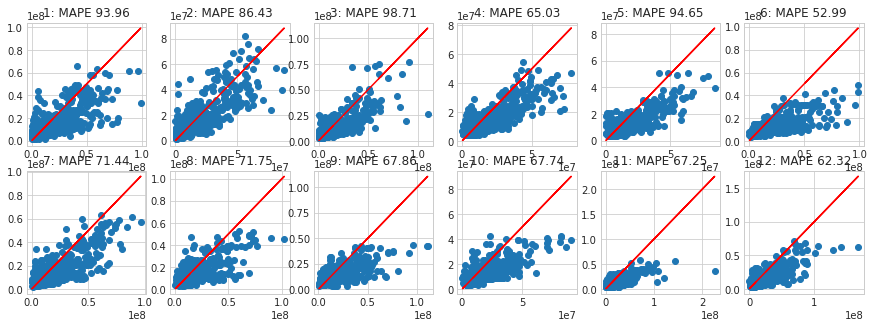

In [36]:
plot_result(cv_test, cv_predict, cv_scores)

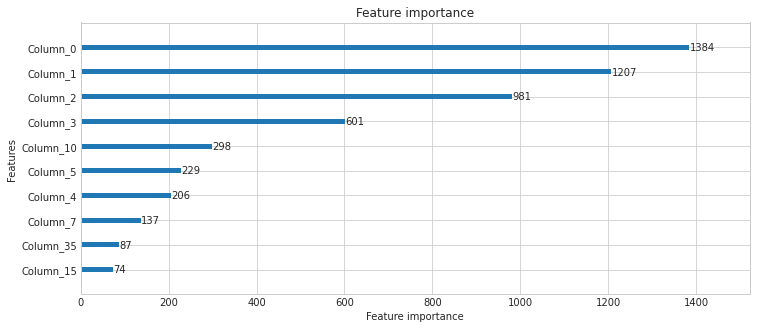

In [37]:
f, ax = plt.subplots(figsize = (12,5))

from lightgbm import plot_importance
plot_importance(cv_models[12], ax, max_num_features=10)

## 가전

In [39]:
## 가전
data.상품명 = data.상품명.str.replace('LG전자', 'LG')
data.상품명 = data.상품명.str.replace('LG', ' LG ')
data.상품명 = data.상품명.str.replace('삼성', ' 삼성 ')

# LG 휘센 에어컨
data.상품명 = data.상품명.str.replace('휘센', '')
data.상품명 = data.상품명.str.replace('싱큐', '')
data.상품명 = data.상품명.str.replace('씽큐', '')
data.상품명 = data.상품명.str.replace('위너', '')
data.상품명 = data.상품명.str.replace('FQ17V9WWA1', '')
data.상품명 = data.상품명.str.replace('FQ19V9KWA2', '')
data.상품명 = data.상품명.str.replace('FQ17V9KWA2', '')
data.상품명 = data.상품명.str.replace('FQ17V8WWJ2', '')
data.상품명 = data.상품명.str.replace('FQ17V9KWA1', '')
data.상품명 = data.상품명.str.replace('FQ19V9KWA1', '')
data.상품명 = data.상품명.str.replace('FQ17V8WWJ1', '')

# 삼성 UHD TV
data.상품명 = data.상품명.str.replace('UHD', '')
data.상품명 = data.상품명.str.replace('UN55NU7010FXKR', '55인치')
data.상품명 = data.상품명.str.replace('UN65NU7010FXKR', '65인치')
data.상품명 = data.상품명.str.replace('UN75NU7010FXKR', '75인치')
data.상품명 = data.상품명.str.replace('UN55NU7050F', '55인치')
data.상품명 = data.상품명.str.replace('UN65NU7050F', '65인치')
data.상품명 = data.상품명.str.replace('UN75NU7050F', '75인치')
data.상품명 = data.상품명.str.replace('UN55RU7150FXKR', '55인치')
data.상품명 = data.상품명.str.replace('UN65RU7150FXKR', '65인치')
data.상품명 = data.상품명.str.replace('UN75RU7150FXKR', '75인치')

# LG 울트라HD TV 
data.상품명 = data.상품명.str.replace('울트라HD', '')
data.상품명 = data.상품명.str.replace('55UK6800HNC', '55인치')
data.상품명 = data.상품명.str.replace('55UM7900BNA', '55인치')
data.상품명 = data.상품명.str.replace('65UK6800HNC', '65인치')
data.상품명 = data.상품명.str.replace('65UM7900BNA', '65인치')
data.상품명 = data.상품명.str.replace('70UK6800HNC', '70인치')
data.상품명 = data.상품명.str.replace('70UK7400KNA', '70인치')
data.상품명 = data.상품명.str.replace('75UK6200KNB', '75인치')
data.상품명 = data.상품명.str.replace('75UK7400KNA', '75인치')
data.상품명 = data.상품명.str.replace('75UM7900BNA', '75인치')

data.상품명 = data.상품명.str.replace('55인치', ' 55인치 ')
data.상품명 = data.상품명.str.replace('65인치', ' 65인치 ')
data.상품명 = data.상품명.str.replace('75인치', ' 75인치 ')
data.상품명 = data.상품명.str.replace('70인치', ' 70인치 ')


# 삼성 엑티브워시 세탁기
data.상품명 = data.상품명.str.replace('엑티브워시', '')
data.상품명 = data.상품명.str.replace('WA14N6781TG', '')

# 삼성 노트북 9 메탈
data.상품명 = data.상품명.str.replace('9 메탈', '')
data.상품명 = data.상품명.str.replace('NT900X5J-K28', '')
data.상품명 = data.상품명.str.replace('NT900X5J-K14', '')

# LG 통돌이 세탁기
data.상품명 = data.상품명.str.replace('통돌이', '')
data.상품명 = data.상품명.str.replace('TR14WK1(화이트)', '', regex = False)

# LG 냉장고
data.상품명 = data.상품명.str.replace('노크온 매직스페이스', '') 
data.상품명 = data.상품명.str.replace('매직스페이스', '') 
data.상품명 = data.상품명.str.replace('S831SN75', '', regex = False)

## 에어컨
data.상품명 = data.상품명.str.replace('에어컨', ' 에어컨 ', regex = False)
data.상품명 = data.상품명.str.replace('2IN1형', ' 홈멀티 ', regex = False)
data.상품명 = data.상품명.str.replace('2in1', ' 홈멀티 ', regex = False)
data.상품명 = data.상품명.str.replace('스탠드형', ' 스탠드 ', regex = False)
data.상품명 = data.상품명.str.replace('FQ17V9KW', '', regex = False)
data.상품명 = data.상품명.str.replace('무풍슬림', '', regex = False)
data.상품명 = data.상품명.str.replace('AF16R5773WSR', '', regex = False)

## 냉장고
data.상품명 = data.상품명.str.replace('딤채', ' 딤채 ', regex = False)
data.상품명 = data.상품명.str.replace('_', '', regex = False)
data.상품명 = data.상품명.str.replace('1등급', '', regex = False)

data.상품명 = data.상품명.str.replace('냉장고', ' 냉장고 ', regex = False)
data.상품명 = data.상품명.str.replace('김치냉장고', ' 김치냉장고 ', regex = False)
data.상품명 = data.상품명.str.replace('김치 냉장고', ' 김치냉장고 ', regex = False)

## 세탁기
data.상품명 = data.상품명.str.replace('세탁기', ' 세탁기 ', regex = False)
data.상품명 = data.상품명.str.replace('TR14WK1', '', regex = False)

## 캐리어 벽걸이에어컨
data.상품명 = data.상품명.str.replace('ARC06NQT', '')
data.상품명 = data.상품명.str.replace('ARC07VBC', '')
data.상품명 = data.상품명.str.replace('6형', '기본형') #?
data.상품명 = data.상품명.str.replace('7형', '고급형') #?

# 대우 벽걸이에어컨
data.상품명 = data.상품명.str.replace('DOZ-S06JK', '기본형') #?
data.상품명 = data.상품명.str.replace('TDOZ-S10JK', '고급형') #?

# 건조기
data.상품명 = data.상품명.str.replace('RH14WN', '14kg') #?
data.상품명 = data.상품명.str.replace('RH16WN', '16kg')

data.상품명 = data.상품명.str.replace('미니건조기', '건조기 3kg')

data.상품명 = data.상품명.str.replace('DWR-03IDDC', '블랙')
data.상품명 = data.상품명.str.replace('DWR-03IDWH', '화이트')

data.상품명 = data.상품명.str.replace('DV90M53B0QV', '블랙')
data.상품명 = data.상품명.str.replace('DV90M53B0QW', '화이트')
data.상품명 = data.상품명.str.replace('DV90M53B0QP', '실버')

def electronic(x):
    if x.상품군 == '가전':
        x.상품명 = x.상품명.replace('청소기', ' 청소기 ')  
    else:
        x.상품명 = x.상품명
    return x

data = data.apply(lambda x: electronic(x), axis = 1)

data.상품명 = data.상품명.str.replace(' +', ' ')
data.상품명 = data.상품명.str.lstrip()
data.상품명 = data.상품명.str.rstrip()

In [40]:
set(data[(data.상품명.str.contains('14kg'))].상품명)

{'LG 트롬 건조기 14kg 화이트'}

In [41]:
word_count = max_words('가전')
max_words_count = sorted(word_count.items(), key = lambda x: x[1], reverse = True)
max_words_count[:25]

[('LG', 3556),
 ('TV', 2266),
 ('삼성', 1048),
 ('에어컨', 946),
 ('65인치', 819),
 ('55인치', 818),
 ('냉장고', 701),
 ('세탁기', 646),
 ('벽걸이', 483),
 ('75인치', 450),
 ('고급형', 419),
 ('기본형', 397),
 ('노트북', 358),
 ('캐리어', 275),
 ('대우전자', 230),
 ('홈멀티', 228),
 ('70인치', 203),
 ('스탠드', 192),
 ('화이트', 79),
 ('김치냉장고', 57),
 ('딤채', 57),
 ('청소기', 56),
 ('공기청정기', 54),
 ('홈', 43),
 ('건조기', 38)]

In [42]:
df = train_df('가전', 24)

In [43]:
cv_scores, cv_models, cv_test, cv_predict = LGBM_train(df)

1월 MAPE: 101.5670273659676
2월 MAPE: 70.56171919170612
3월 MAPE: 55.96350499488544
4월 MAPE: 56.89269098691639
5월 MAPE: 84.99695662397407
6월 MAPE: 115.540645121442
7월 MAPE: 88.01841167101414
8월 MAPE: 68.74296606983403
9월 MAPE: 53.69097385635205
10월 MAPE: 53.260454118263866
11월 MAPE: 64.50295883865346
12월 MAPE: 51.142740435508586


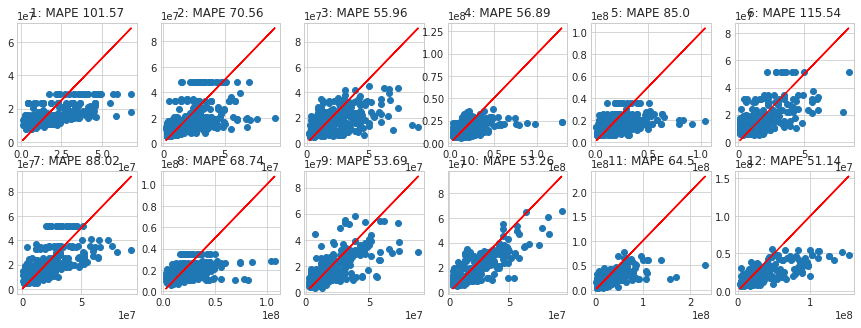

In [44]:
plot_result(cv_test, cv_predict, cv_scores)

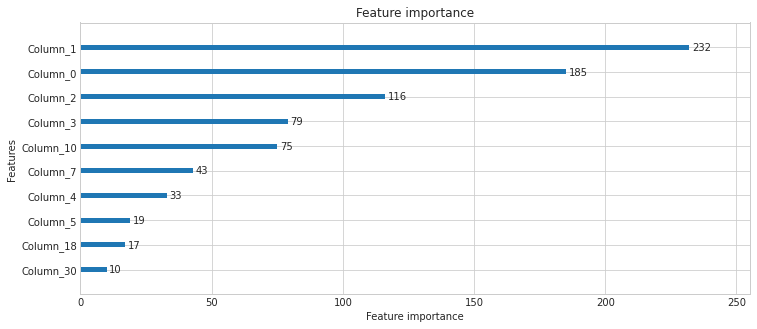

In [45]:
f, ax = plt.subplots(figsize = (12,5))

from lightgbm import plot_importance
plot_importance(cv_models[1], ax, max_num_features=10)

In [270]:
def print_importance(*args):
    for a in args:
        print_df = df.drop(columns = ['취급액_로그', '월'])
        print(print_df.columns[a])

In [271]:
print_importance(7,1,2,3,11,10,4,27,5,6)

Middle
일
시
요일
70인치
65인치
휴일
에어컨
프라임
First


## 의류

In [ ]:
def clothes(x):
    if x.상품군 == '의류':
        x.상품명 = x.상품명.replace('SS', 'S/S')
        x.상품명 = x.상품명.replace('K-SWIS/S', 'K-SWISS')
        x.상품명 = x.상품명.replace('FW', 'F/W')
        x.상품명 = x.상품명.replace('S/S', ' S/S ')
        x.상품명 = x.상품명.replace('F/W', ' F/W ')

        x.상품명 = x.상품명.replace('기모', ' 기모 ')
        x.상품명 = x.상품명.replace('니트', ' 니트 ')
        x.상품명 = x.상품명.replace('팬츠', ' 팬츠 ')        
        x.상품명 = x.상품명.replace('데님 팬츠', ' 데님 ')
        x.상품명 = x.상품명.replace('티셔츠', ' 티셔츠 ')
        x.상품명 = x.상품명.replace('밴딩', ' 밴딩 ')

        x.상품명 = x.상품명.replace('코트', ' 코트 ')
        x.상품명 = x.상품명.replace('밍크', ' 밍크 ')
        x.상품명 = x.상품명.replace('그레이스', ' 그레이스 ')
    else:
        x.상품명 = x.상품명
    return x

data = data.apply(lambda x: clothes(x), axis = 1)

data.상품명 = data.상품명.str.replace('CERINI by PAT', 'CERINI_by_PAT') 
data.상품명 = data.상품명.str.replace('USPA', 'USPA ')

## 마르엘라로사티
data.상품명 = data.상품명.str.replace('풀스킨', '')
data.상품명 = data.상품명.str.replace('휘메일', '') #?

data.상품명 = data.상품명.str.replace('트랙수트', ' 트랙수트 ')

data.상품명 = data.상품명.str.replace(' +', ' ')
data.상품명 = data.상품명.str.lstrip()
data.상품명 = data.상품명.str.rstrip()

In [ ]:
set(data[data.상품명.str.contains('그레이스')].상품명)

{'루이띠에 18k 그레이스 골드 귀걸이',
 '루이띠에 18k 그레이스 골드 목걸이',
 '루이띠에 18k 그레이스 골드 목걸이팔찌 세트',
 '루이띠에 18k 그레이스 골드 반지',
 '루이띠에 18k 그레이스 골드 주얼리 세트',
 '루이띠에 18k 그레이스 골드 팔찌',
 '루이띠에 18k 그레이스 골드 팔찌반지 세트',
 '헤스티지 그레이스 양가죽 코트'}

In [ ]:
word_count = max_words('의류')
max_words_count = sorted(word_count.items(), key = lambda x: x[1], reverse = True)
max_words_count[:50]

[('코트', 668),
 ('팬츠', 577),
 ('티셔츠', 566),
 ('데님', 451),
 ('K-SWISS', 440),
 ('S/S', 420),
 ('썸머', 416),
 ('뱅뱅', 413),
 ('세트', 342),
 ('밍크', 309),
 ('F/W', 304),
 ('트랙수트', 298),
 ('헤스티지', 280),
 ('마르엘라로사티', 269),
 ('기모', 267),
 ('NNF', 246),
 ('CERINI_by_PAT', 242),
 ('USPA', 232),
 ('패딩', 231),
 ('니트', 220),
 ('롱', 208),
 ('임페리얼', 207),
 ('보코', 200),
 ('컬렉션', 192),
 ('그렉노먼', 175),
 ('폴로셔츠', 171),
 ('크리스티나앤코', 167),
 ('봄', 162),
 ('양가죽', 159),
 ('베스트', 153),
 ('헤비추얼', 150),
 ('후드', 149),
 ('스트레치', 141),
 ('코몽트', 130),
 ('릴렉스', 128),
 ('에어핏', 126),
 ('테이트', 121),
 ('화이트라벨', 118),
 ('PK', 114),
 ('트레이닝', 111),
 ('대동모피', 102),
 ('본딩', 99),
 ('마리노블', 98),
 ('밴딩', 96),
 ('아웃도어', 94),
 ('자켓', 93),
 ('그레이스', 87),
 ('카라', 84),
 ('엘레나', 76),
 ('콤비', 76)]

## 속옷

In [ ]:
## 에버라스트 드로즈
data.상품명 = data.상품명.str.replace('10+', '', regex = False)

# 헤드
data.상품명 = data.상품명.str.replace('파이로라이트', '', regex = False)

# 로베르타 디 까메리노
data.상품명 = data.상품명.str.replace('로베르타 디 까메리노', '로베르타_디_까메리노')

data.상품명 = data.상품명.str.replace('브라탑', ' 브라탑 ')
data.상품명 = data.상품명.str.replace('브라팬티', '브라 팬티')
data.상품명 = data.상품명.str.replace('브라', ' 브라')
data.상품명 = data.상품명.str.replace('팬티', '팬티 ')
data.상품명 = data.상품명.str.replace('패키지', ' 패키지 ')
data.상품명 = data.상품명.str.replace('드로즈', '드로즈 ')
data.상품명 = data.상품명.str.replace('DRY-CELL', '드라이셀')
data.상품명 = data.상품명.str.replace('DRY-DELL', '드라이셀')
data.상품명 = data.상품명.str.replace('라이크라', ' 라이크라 ')
data.상품명 = data.상품명.str.replace('쉐이핑', ' 쉐이핑 ')

data.상품명 = data.상품명.str.replace('프레쉬', '')
data.상품명 = data.상품명.str.replace('데오', '')
data.상품명 = data.상품명.str.replace('델타', '')
data.상품명 = data.상품명.str.replace('피트니스', '')
data.상품명 = data.상품명.str.replace('INNO', '')
data.상품명 = data.상품명.str.replace('프런트후크', '')
data.상품명 = data.상품명.str.replace('옴니위크', '')
data.상품명 = data.상품명.str.replace('옴니히트', '')

data.상품명 = data.상품명.str.replace('퍼융기모', '')
data.상품명 = data.상품명.str.replace('융기모', '')

def underwear(x):
    if x.상품군 == '속옷':
        x.상품명 = x.상품명.replace('블랙', '')
    else:
        x.상품명 = x.상품명   
    return x

data = data.apply(lambda x: clothes(x), axis = 1)


data.상품명 = data.상품명.str.replace(' +', ' ')
data.상품명 = data.상품명.str.lstrip()
data.상품명 = data.상품명.str.rstrip()

In [ ]:
set(data[data.상품명.str.contains('쉐이핑')].상품명)

{'댄스킨 매쉬 풀커버 쉐이핑 브라 패키지',
 '레이프릴 네추럴 쿨 쉐이핑 브라 패키지',
 '레이프릴 풍기인견 복부 쉐이핑 거들팬티',
 '로베르타_디_까메리노 360커브드 지퍼 쉐이핑 란쥬',
 '로베르타_디_까메리노 Y밸런스업 지퍼 쉐이핑 란쥬',
 '로베르타_디_까메리노 밸런스업 지퍼 쉐이핑 란쥬 패키지',
 '로베르타_디_까메리노 트리플커버 지퍼 쉐이핑 란쥬',
 '오가닉뷰티 황후의 코르셋 리얼 쉐이핑 팬티 패키지',
 '오모떼 리얼스킨 쉐이핑 브라 팬티',
 '오모떼 미라클 쉐이핑 브라 팬티',
 '오모떼 쉐이핑 브라 팬티',
 '오모떼 쉐이핑 차 브라 팬티',
 '오모떼 오리지널 쉐이핑 브라 팬티',
 '푸마 드라이셀 쉐이핑 레깅스'}

In [ ]:
word_count = max_words('속옷')
max_words_count = sorted(word_count.items(), key = lambda x: x[1], reverse = True)
max_words_count[:50]

[('패키지', 1547),
 ('푸마', 1013),
 ('드로즈', 814),
 ('브라', 737),
 ('팬티', 533),
 ('드라이셀', 413),
 ('트렁크', 296),
 ('심리스', 286),
 ('레이스', 278),
 ('오모떼', 272),
 ('쉐이핑', 268),
 ('에버라스트', 263),
 ('컬럼비아', 230),
 ('풍기인견', 225),
 ('코튼', 221),
 ('헤드', 212),
 ('라이크라', 208),
 ('레이프릴', 206),
 ('란쥬', 200),
 ('리복', 191),
 ('아키', 181),
 ('쿠미투니카', 180),
 ('카파', 170),
 ('풀커버', 159),
 ('동내의', 142),
 ('세트', 141),
 ('브라탑', 138),
 ('쿨', 134),
 ('롱드로즈', 133),
 ('로베르타_디_까메리노', 129),
 ('언더셔츠', 126),
 ('런닝', 126),
 ('블랙', 126),
 ('레깅스', 115),
 ('라쉬반', 110),
 ('지퍼', 105),
 ('치마레깅스', 104),
 ('베이스레이어', 102),
 ('원피스', 102),
 ('극세사', 90),
 ('7세트', 90),
 ('히트융', 90),
 ('브라세트', 89),
 ('스피드윅', 79),
 ('컬렉션', 79),
 ('크로커다일', 77),
 ('데일리', 75),
 ('캐리어', 74),
 ('풀컵', 72),
 ('와이드', 72)]

## 농수축 & 건강기능


In [ ]:
# 멋진밥상 흥양농협 쌀 20kg
data.상품명 = data.상품명.str.replace('햅쌀', '쌀')
data.상품명 = data.상품명.str.replace('멋진밥상 흥양농협', '')

## 안동간고등어 & 우리바다 손질왕꼬막
data.상품명 = data.상품명.str.replace('안동간고등어', '고등어')

# 생선
data.상품명 = data.상품명.str.replace('고등어', ' 고등어 ')
data.상품명 = data.상품명.str.replace('갈치', ' 갈치 ')
data.상품명 = data.상품명.str.replace('광어', ' 광어 ')
data.상품명 = data.상품명.str.replace('갑오징어', ' 오징어 ')
data.상품명 = data.상품명.str.replace('통오징어', ' 오징어 ')
data.상품명 = data.상품명.str.replace('전복', ' 전복 ')
data.상품명 = data.상품명.str.replace('왈도활', '')


# 영광 生 모시떡
data.상품명 = data.상품명.str.replace('영광 生', '')
data.상품명 = data.상품명.str.replace('동부기피+검정깨', '', regex=False)

# 옛날쥐포 110장
data.상품명 = data.상품명.str.replace('옛날', '', regex=False)
data.상품명 = data.상품명.str.replace('110장', '', regex=False)


data.상품명 = data.상품명.str.replace(' 그 ', ' ', regex=False)
data.상품명 = data.상품명.str.replace('x', '', regex=False)
data.상품명 = data.상품명.str.replace('손질', ' 손질 ', regex=False)
data.상품명 = data.상품명.str.replace('햇', '', regex=False)
data.상품명 = data.상품명.str.replace('총', '', regex=False)

# 셰프
data.상품명 = data.상품명.str.replace('AAB의', '', regex=False)
data.상품명 = data.상품명.str.replace('유귀열의', '', regex=False)
data.상품명 = data.상품명.str.replace('임성근의', '', regex=False)

data.상품명 = data.상품명.str.replace('청정수산', '', regex=False)
data.상품명 = data.상품명.str.replace('깐깐송도순', '', regex=False)
data.상품명 = data.상품명.str.replace('현대어찬', '', regex=False)
data.상품명 = data.상품명.str.replace('하늘내린', '', regex=False)
data.상품명 = data.상품명.str.replace('소들녘', '', regex=False)
data.상품명 = data.상품명.str.replace('피시원', '', regex=False)
data.상품명 = data.상품명.str.replace('우리바다', '', regex=False)


# 두유
data.상품명 = data.상품명.str.replace('검은콩', '', regex=False)
data.상품명 = data.상품명.str.replace('고칼슘', '', regex=False)
data.상품명 = data.상품명.str.replace('호두아몬드', '', regex=False)

# The 귀한
data.상품명 = data.상품명.str.replace('The 귀한', '', regex=False)
data.상품명 = data.상품명.str.replace('The귀한', '', regex=False)
data.상품명 = data.상품명.str.replace('귀한', '', regex=False)
data.상품명 = data.상품명.str.replace('무료체험', '', regex=False) #?

# 김치
data.상품명 = data.상품명.str.replace('갓김치', '김치', regex=False)
data.상품명 = data.상품명.str.replace('포기김치', '김치', regex=False)
data.상품명 = data.상품명.str.replace('각김치', '김치', regex=False)
data.상품명 = data.상품명.str.replace('백김치', '김치', regex=False)


data.상품명 = data.상품명.str.replace(' +', ' ')
data.상품명 = data.상품명.str.lstrip()
data.상품명 = data.상품명.str.rstrip()

In [ ]:
set(data[data.상품명.str.contains('하림')].상품명)

{'하림 치킨스테이크 4봉', '하림뼈없는양념닭발세트'}

In [ ]:
word_count = max_words('농수축')
max_words_count = sorted(word_count.items(), key = lambda x: x[1], reverse = True)
max_words_count[:30]

[('손질', 979),
 ('국내산', 639),
 ('김치', 442),
 ('오징어', 410),
 ('고등어', 326),
 ('쌀', 264),
 ('소곱창전골', 252),
 ('두유', 244),
 ('모시떡', 182),
 ('전복', 157),
 ('풀세트', 147),
 ('녹용도가니탕', 147),
 ('문어', 146),
 ('완도활', 136),
 ('자연산', 135),
 ('갈치', 118),
 ('쥐포', 116),
 ('꽃게', 99),
 ('갈비탕', 91),
 ('용대리황태', 83),
 ('궁중', 81),
 ('소', 80),
 ('동태포', 78),
 ('새우', 78),
 ('!!', 76),
 ('찰보리식혜', 70),
 ('하림뼈없는양념닭발세트', 69),
 ('홍어', 68),
 ('영산포숙성', 68),
 ('왕꼬막', 66)]

In [ ]:
word_count = max_words('건강기능')
max_words_count = sorted(word_count.items(), key = lambda x: x[1], reverse = True)
max_words_count[:30]

[('종근당건강', 253),
 ('생유산균골드', 199),
 ('락토핏', 199),
 ('단하루', 178),
 ('석류', 115),
 ('루테인', 93),
 ('정직한', 84),
 ('농부의', 84),
 ('닥터', 81),
 ('뉴트리원', 75),
 ('다이어트', 74),
 ('구미', 72),
 ('슈퍼', 57),
 ('아이클리어', 36),
 ('직매입', 36),
 ('프리바이오틱스', 33),
 ('석류즙', 32),
 ('무농약레드비트즙', 30),
 ('90봉', 30),
 ('통째로', 26),
 ('착즙한', 26),
 ('루비', 26),
 ('한삼인순홍삼진', 24),
 ('100%리얼착즙석류', 24),
 ('플러스', 24),
 ('백', 24),
 ('오메가3', 24),
 ('양배추진액', 20),
 ('제주농장', 20),
 ('유기', 20)]

In [ ]:
data[data.상품군=='건강기능'].상품명.value_counts()[:50]

종근당건강 락토핏 생유산균골드 단하루                175
정직한 농부의 석류                           84
뉴트리원 다이어트 구미                         66
닥터 슈퍼 루테인                            57
직매입 종근당건강 아이클리어 루테인                  36
무농약레드비트즙 90봉                         30
통째로 착즙한 루비 석류즙                       26
한삼인순홍삼진 백                            24
100%리얼착즙석류                           24
닥터 프리바이오틱스 플러스                       24
종근당건강 락토핏 생유산균골드                     24
제주농장 유기 양배추진액                        20
광동제약 석류 100,                         19
뉴질랜드 초록입홍합 환 100%                    15
안국루테인 미니100                          12
콜라겐3.2 아임파인 월                        12
블랙모어스 알티지 오메가3 3병 53주분               12
리얼니파팜 해죽순                            12
" 100%리얼 착즙 석류 ",                    12
베지밀 두유                                9
경남제약 레모나 S산                           9
종근당건강 프로메가 오메가3 파워                    9
한국인 모유유래 다이어트 유산균 BNR17 비에날씬 12주      8
특집 이롬 황성주1일1생식 스페셜                    8
프리바이오틱스 3300 월분                       6


## 잡화

In [ ]:
# 잡화
data.상품명 = data.상품명.str.replace('18k', '18K')
data.상품명 = data.상품명.str.replace('목걸이', ' 목걸이 ')
data.상품명 = data.상품명.str.replace('팔찌', ' 팔찌 ')
data.상품명 = data.상품명.str.replace('반지', ' 반지 ')
data.상품명 = data.상품명.str.replace('주얼리', ' 주얼리 ')
data.상품명 = data.상품명.str.replace('골드바', ' 골드바 ')
data.상품명 = data.상품명.str.replace('골드 ', '')
data.상품명 = data.상품명.str.replace('크로스바디백', '크로스백', regex = False)


## 가이거 워치
data.상품명 = data.상품명.str.replace('다이아몬드', '', regex = False)
data.상품명 = data.상품명.str.replace('콘체르토', '', regex = False)

data.상품명 = data.상품명.str.replace('카이만', ' 카이만 ', regex = False)
data.상품명 = data.상품명.str.replace('악어', '', regex = False)
data.상품명 = data.상품명.str.replace('리얼', '', regex = False)
data.상품명 = data.상품명.str.replace('엠보', ' 엠보 ', regex = False)
data.상품명 = data.상품명.str.replace('테스토', '', regex = False)

# 루이띠에 (? 이름있는 브랜드인지?)
data.상품명 = data.상품명.str.replace('그레이스', '', regex = False)
data.상품명 = data.상품명.str.replace('베르니아', '', regex = False)


data.상품명 = data.상품명.str.replace('알비에로 마르티니', '알비에로_마르티니', regex = False)
data.상품명 = data.상품명.str.replace('1A', '', regex = False)
data.상품명 = data.상품명.str.replace('클라쎄', '', regex = False)
data.상품명 = data.상품명.str.replace('시그니처', '', regex = False)
data.상품명 = data.상품명.str.replace('RYN 린', 'RYN', regex = False)
data.상품명 = data.상품명.str.replace('켈시', '', regex = False)

def stuff(x):
    if x.상품군 == '잡화':
        x.상품명 = x.상품명.replace('에어', '')
        x.상품명 = x.상품명.replace('주얼리', '')
        x.상품명 = x.상품명.replace('SS', 'S/S')
    else:
        x.상품명 = x.상품명
    return x

data = data.apply(lambda x: stuff(x), axis = 1)

data.상품명 = data.상품명.str.replace(' +', ' ')
data.상품명 = data.상품명.str.lstrip()
data.상품명 = data.상품명.str.rstrip()

In [ ]:
word_count = max_words('잡화')
max_words_count = sorted(word_count.items(), key = lambda x: x[1], reverse = True)
max_words_count[:50]

[('루이띠에', 406),
 ('소가죽', 365),
 ('세트', 364),
 ('코치', 357),
 ('프라다', 342),
 ('18K', 331),
 ('카이만', 331),
 ('크로스백', 280),
 ('삭루츠', 279),
 ('월드컵', 272),
 ('가이거', 246),
 ('러닝화', 228),
 ('토트백', 219),
 ('엠보', 219),
 ('백', 212),
 ('숄더백', 200),
 ('워치', 198),
 ('도스문도스', 195),
 ('선글라스', 184),
 ('팔찌', 174),
 ('트레킹화', 158),
 ('목걸이', 152),
 ('아가타', 141),
 ('S/S', 138),
 ('워킹화', 126),
 ('샌들', 126),
 ('백팩', 124),
 ('칼리베이직', 123),
 ('사첼백', 121),
 ('핸드백', 96),
 ('여행가방', 93),
 ('슬립온', 91),
 ('AAD', 89),
 ('순금', 89),
 ('체인', 86),
 ('안드레아바나', 86),
 ('알비에로_마르티니', 84),
 ('트레스패스', 84),
 ('F/W', 83),
 ('에펨', 82),
 ('반지', 80),
 ('플랫슈즈', 76),
 ('RYN', 72),
 ('펌프스', 69),
 ('구찌', 69),
 ('레코바', 66),
 ('슬리퍼', 66),
 ('스니커즈', 66),
 ('로베르타_디_까메리노', 65),
 ('골드바', 64)]

In [ ]:
data[data.상품군=='잡화'].상품명.value_counts()[:50]

가이거 워치                      174
트레스패스 워킹화 + 러닝화              66
칼리베이직 백 세트                   63
도스문도스 카이만 엠보 소가죽 토트백         57
칼리베이직 패브릭 백                  57
코치 사첼백                       54
레코바 다이얼워킹화세트                 54
S/S 엘리자베스아덴 선글라스             54
도스문도스 카이만 엠보 소가죽 핸드백         54
삭루츠 투 웨이 백팩 TQ55             51
가이거 제니스시계 세트                 48
월드컵 러닝화+트레킹화                 48
프라다 크로스백                     48
RYN 다이얼락 히트 웜 퍼 방한화          48
월드컵 러닝화+슬리퍼                  48
루이띠에 18K 세트                  47
루이띠에 18K 귀걸이                 46
도스문도스 카이만 엠보 소가죽 체인 숄더백      45
루이띠에 18K 목걸이                 44
AAA F/W 트레킹화                 44
루이띠에 18K 팔찌                  43
S/S 로베르타_디_까메리노 선글라스         42
썸덱스 트로이카 여행가방 세트             42
코치 베네트 사첼백                   42
월드컵 워킹화+슬립온                  42
월드컵 러닝화+아쿠아트레킹화              42
오델로 겨울모자                     40
루이띠에 18K 목걸이 팔찌 세트           36
아가타 골든 마스터 펌프스+플랫슈즈          36
AAD 소가죽 올데이슬립온               35
루이띠에 18K 반지                  34
삭루츠 크로스백

## 이미용

In [90]:
# 비버리힐스폴로클럽
data.상품명 = data.상품명.str.replace('골드+콜라겐', '', regex=False) 
data.상품명 = data.상품명.str.replace('FW골드', '', regex=False) 
data.상품명 = data.상품명.str.replace('골드+플라', '', regex=False) 
data.상품명 = data.상품명.str.replace('플라센타아이크림+선크림', '', regex=False) 

## 참존 탑뉴스 지이링클 기초세트
data.상품명 = data.상품명.str.replace('탑뉴스 지이링클', '') 


data.상품명 = data.상품명.str.replace(' +', ' ')
data.상품명 = data.상품명.str.lstrip()
data.상품명 = data.상품명.str.rstrip()

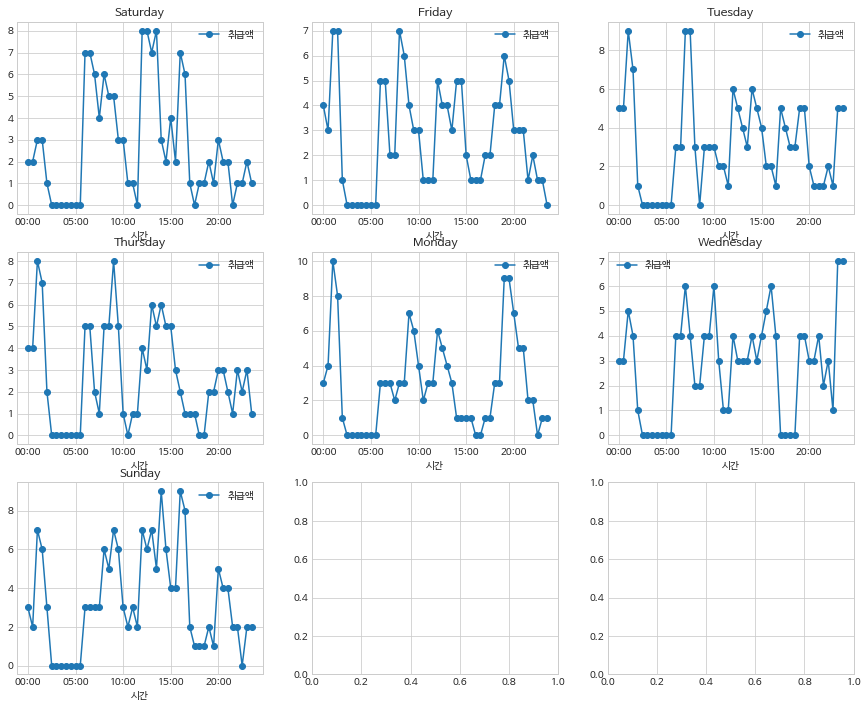

In [91]:
data_이미용 = data[data.상품군 == '이미용']
data_이미용.index = pd.to_datetime(data_이미용.index)

plot_df = data_이미용.resample('30T').sum()['취급액'].to_frame()
plot_df['요일'] = plot_df.index.strftime('%A')
plot_df['시간'] = plot_df.index.strftime('%H:%M')
plot_df['취급액'] = plot_df.취급액.map(lambda x: np.NaN if x == 0 else x)

plot_df = plot_df.groupby(['요일','시간']).count()

weekday =  list(set(plot_df.index.get_level_values(0)))
fig,  ax = plt.subplots(3,3, figsize = (15, 12))
for i in range(7):
    df_ = plot_df.loc[weekday[i]]
    x = i//3
    y = i%3
    df_.plot(ax = ax[x, y], marker = 'o', )
    ax[x, y].set_title(weekday[i])

In [92]:
data[data.상품명.str.contains('VONIN', regex=False)][5:]

,노출(분),상품명,상품군,판매단가,취급액,월,일,시,분,요일,휴일,프라임,판매수량,First,Middle,Last,취급액_로그,결제유형
방송일시,,,,,,,,,,,,,,,,,,
2019-09-04 19:40:00,20.0,VONIN 보닌 남성기초세트,이미용,54000,74682000.0,9,4,19,40,Wednesday,0,3,1383.000000,0.0,0.0,1.0,18.128750,0
2019-09-14 09:00:00,20.0,VONIN 보닌 남성기초세트,이미용,54000,47749000.0,9,14,9,0,Saturday,2,1,884.240741,1.0,0.0,0.0,17.681469,0
2019-09-14 09:20:00,20.0,VONIN 보닌 남성기초세트,이미용,54000,66569000.0,9,14,9,20,Saturday,2,1,1232.759259,0.0,1.0,0.0,18.013750,0
2019-09-14 09:40:00,20.0,VONIN 보닌 남성기초세트,이미용,54000,60378000.0,9,14,9,40,Saturday,2,1,1118.111111,0.0,0.0,1.0,17.916135,0
2019-09-26 19:00:00,20.0,VONIN 보닌 남성기초세트,이미용,54000,35598000.0,9,26,19,0,Thursday,0,3,659.222222,1.0,0.0,0.0,17.387800,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-12-26 21:40:00,20.0,VONIN 보닌 남성기초세트,이미용,54000,57823000.0,12,26,21,40,Thursday,0,4,1070.796296,0.0,1.0,0.0,17.872897,0
2019-12-26 22:00:00,20.0,VONIN 보닌 남성기초세트,이미용,54000,61928000.0,12,26,22,0,Thursday,0,4,1146.814815,0.0,0.0,1.0,17.941483,0
2019-12-29 10:20:00,20.0,VONIN 보닌 남성기초세트,이미용,54000,36735000.0,12,29,10,20,Sunday,1,2,680.277778,1.0,0.0,0.0,17.419241,0


In [93]:
data[data.상품군=='이미용'].상품명.value_counts()[:50]

비버리힐스폴로클럽 남성기초세트                   339
비버리힐스폴로클럽 남성기초세트 2018              149
참존 기초세트                            141
VONIN 보닌 남성기초세트                     82
엘렌실라 에스까르고에센스 커버쿠션                  60
실크테라피 오리지널 에센스 패키지                  53
네오젠 에이지큐어 원미닛 링클 리프트                52
바바코코 젤네일스트립 SET                     30
라라츄 틴트 아이브로우 바                      30
엘렌실라 달팽이크림 콜라겐5+팩트3                 27
스포메틱스 트리플 샤이닝 쿠션시즌1                 24
마리끌레르 파리컬렉션 리얼 하이드로 립스틱 마스카라        21
엘렌실라 그린 에너지 썬스틱7                    21
아이앤아이 퀵래쉬 속눈썹세트                     21
아미니 비노테라 오일 워시 구성2                  18
아미니 비노테라 오일 워시 구성1                  18
더블모 어성초 샴푸                          15
미바 이온칼슘 파운데이션 더블쿠션 RX               15
엘렌실라&코즈미 쑥클렌져 단하루                   12
마리끌레르 파리컬렉션 리얼 하이드로 립스틱 2019리뉴얼     12
자올 닥터스오더 탈모 부스터&샴푸                  11
프리미엄 클린샤워                            9
마리끌레르 파리컬렉션 리얼 하이드로 립스틱 리뉴얼          9
파시노 이지앤퀵 빗살 뿌리펌                      9
NEW프리미엄 TS샴푸/트리트먼트 추가                8
에이유플러스 슈퍼선스틱 1001 쇼퍼백    

## 가구 & 침구 & 생활용품

In [ ]:
data.상품명 = data.상품명.str.replace('싱글사이즈', ' 싱글 ')

data.상품명 = data.상품명.str.replace('퀸사이즈', ' 퀸 ')
data.상품명 = data.상품명.str.replace('Q 퀸', ' 퀸 ')
data.상품명 = data.상품명.str.replace('Q(퀸)', ' 퀸 ', regex = False)

data.상품명 = data.상품명.str.replace('킹사이즈', ' 킹 ')
data.상품명 = data.상품명.str.replace('K 킹', ' 킹 ')
data.상품명 = data.상품명.str.replace('K(킹)', ' 킹 ', regex = False)

data.상품명 = data.상품명.str.replace('SK(슈퍼킹)', ' 슈퍼킹 ', regex = False)
data.상품명 = data.상품명.str.replace('SS 슈퍼싱글', ' 슈퍼싱글 ', regex = False)
data.상품명 = data.상품명.str.replace('SS(슈퍼싱글)', ' 슈퍼싱글 ', regex = False)


def bedsize(x):
    if x.상품군 == '가구' or x.상품군 == '침구' or x.상품군 == '생활용품':
        x.상품명 = x.상품명.replace('K', ' 킹 ')
        x.상품명 = x.상품명.replace('Q', ' 퀸 ')
        x.상품명 = x.상품명.replace('SS', '슈퍼싱글')
        x.상품명 = x.상품명.replace('S', '싱글')
    else:
        x.상품명 = x.상품명   
    return x

data = data.apply(lambda x: bedsize(x), axis = 1)

# 보루네오
data.상품명 = data.상품명.str.replace('피올레', '', regex = False)
data.상품명 = data.상품명.str.replace('천연소가죽', '', regex = False)
data.상품명 = data.상품명.str.replace('유로탑', '', regex = False)
data.상품명 = data.상품명.str.replace('루나', '', regex = False)
data.상품명 = data.상품명.str.replace('시즌2', '', regex = False)

# 보루네오 침대
data.상품명 = data.상품명.str.replace('멀티수납형', '', regex = False)
data.상품명 = data.상품명.str.replace('멀티 수납형', '', regex = False)
data.상품명 = data.상품명.str.replace('서랍형', '', regex = False)
data.상품명 = data.상품명.str.replace('가죽 침대', '가죽침대', regex = False)
data.상품명 = data.상품명.str.replace('LED', '', regex = False) # LED가 들어간 제품 대부분이 침대

# 한샘
data.상품명 = data.상품명.str.replace('한샘', ' 한샘 ')

# 삼익가구 
data.상품명 = data.상품명.str.replace('제니비', '') ## 서랍형 침대
data.상품명 = data.상품명.str.replace('어블러', '') ## 멀티수납형 침대

# 장수흙침대
data.상품명 = data.상품명.str.replace('장수흙침대', '장수 흙침대', regex = False)

# 소파
data.상품명 = data.상품명.str.replace('소파', ' 소파 ', regex = False)
data.상품명 = data.상품명.str.replace('침구세트', ' 침구세트 ')

data.상품명 = data.상품명.str.replace(' +', ' ')
data.상품명 = data.상품명.str.lstrip()
data.상품명 = data.상품명.str.rstrip()

In [ ]:
data[data.상품군=='가구'].상품명.value_counts()[:50]

보루네오 소파                               539
보루네오 수납형 침대 슈퍼싱글                      252
보루네오 수납형 침대 킹                         252
보루네오 수납형 침대 퀸                         251
삼익가구 침대 슈퍼싱글                          145
삼익가구 침대 퀸                             143
삼익가구 침대 킹                             134
삼익가구 수납형 침대 슈퍼싱글                       75
삼익가구 수납형 침대 퀸                          72
삼익가구 수납형 침대 킹                          65
장수 흙침대 퀸                               50
장수 흙침대 싱글                              49
한샘 HG 화이트 실버슬림 붙박이장                    47
장수 클래식 흙카우치                            33
한샘 모데나 프리미엄 슬라이딩 붙박이장                  22
이누스바스 시공 패키지                           13
한샘 하이바스 내추럴 기본형                        11
보루네오 가죽침대 킹                            11
보루네오 가죽침대 퀸                            10
보루네오 심플 광폭 서랍장 800 3단                   9
보루네오 심플 광폭 서랍장 800 5단                   9
레스토닉 블루투스 서랍 침대 퀸                       9
레스토닉 블루투스 서랍 침대 슈퍼싱글                    9
레스토닉 블루투스 서랍 침대 킹                 

In [ ]:
# 선일금고 
data.상품명 = data.상품명.str.replace('선일금고 이볼브 시리즈', ' 금고 ')
data.상품명 = data.상품명.str.replace('EV-020', '')
data.상품명 = data.상품명.str.replace('EV-040', '')

## 일월 매트
data.상품명 = data.상품명.str.replace('품안애', ' ')

## 노비타 비데
data.상품명 = data.상품명.str.replace('노비타', ' ')
data.상품명 = data.상품명.str.replace('무료설치', ' ')

data.상품명 = data.상품명.str.replace('무선', ' 무선 ')

# 타이거 충전식 예초기
data.상품명 = data.상품명.str.replace('타이거 충전식', '')

data.상품명 = data.상품명.str.replace('국내제조', '')
data.상품명 = data.상품명.str.replace('엘사', '')


def household(x):
    if x.상품군 == '생활용품':
        x.상품명 = x.상품명.replace('스마트', '')
        x.상품명 = x.상품명.replace('온열', '')
        x.상품명 = x.상품명.replace('온수', '')
        x.상품명 = x.상품명.replace('에너지세이브', '')
    else:
        x.상품명 = x.상품명
    return x

data = data.apply(lambda x: household(x), axis = 1)

data.상품명 = data.상품명.str.replace(' +', ' ')
data.상품명 = data.상품명.str.lstrip()
data.상품명 = data.상품명.str.rstrip()

In [ ]:
set(data[(data.상품명.str.contains('엘사'))].상품명)

set()

In [ ]:
word_count = max_words('생활용품')
max_words_count = sorted(word_count.items(), key = lambda x: x[1], reverse = True)
max_words_count[:30]

[('일월', 638),
 ('매트', 497),
 ('무선', 391),
 ('싱글', 333),
 ('비데', 277),
 ('퀸', 267),
 ('금고', 255),
 ('킹', 194),
 ('예초기', 184),
 ('청소기', 177),
 ('카페트매트', 162),
 ('세트', 147),
 ('바로바로', 135),
 ('리빙박스', 127),
 ('순면', 116),
 ('뉴스파', 109),
 ('더블', 102),
 ('파격가', 99),
 ('배터리', 92),
 ('코이모', 73),
 ('노송가구', 72),
 ('제이드', 72),
 ('비취', 72),
 ('교자상', 72),
 ('물걸레', 69),
 ('MD-970', 66),
 ('롤링마사지기', 66),
 ('메디컬드림', 66),
 ('니봇', 54),
 ('진공', 54)]

In [ ]:
# 미사여구
data.상품명 = data.상품명.str.replace('국내제조', '', regex = False)
data.상품명 = data.상품명.str.replace('단하루', '', regex = False)

In [ ]:
data.상품명 = data.상품명.str.replace('기본형', '')
data.상품명 = data.상품명.str.replace('고급형', '')
data.상품명 = data.상품명.str.replace('프리미엄형', '')

data.상품명 = data.상품명.str.replace('중형', '')
data.상품명 = data.상품명.str.replace('대형', '')
data.상품명 = data.상품명.str.replace('특대형', '')
data.상품명 = data.상품명.str.replace('점보특대형', '')
data.상품명 = data.상품명.str.replace('슈퍼특대형', '')

# max_word_count


In [ ]:
words = ' '.join(list(data.상품명.dropna().values))

import re
words = re.split(r'[()+ ]', words)
words = list(filter(lambda x: x != '', words))

def max_words(text):
    word_count = {}
    for word in set(words):
        count = words.count(word)
        word_count.update({word:count})
    return word_count

word_count = max_words(words)
max_words_count = sorted(word_count.items(), key = lambda x: x[1], reverse = True)

In [ ]:
set(data[data.상품명.str.contains('형')].상품명)

{'김병지 거미손 풀확장 일체형 코일카매트',
 '보루네오 수납형 침대 슈퍼싱글',
 '보루네오 수납형 침대 퀸',
 '보루네오 수납형 침대 킹',
 '삼익가구 수납형 침대 슈퍼싱글',
 '삼익가구 수납형 침대 퀸',
 '삼익가구 수납형 침대 킹',
 '아키 조끼형 더블보정 란쥬 쉐이퍼',
 '점보형 일월 카페트매트',
 '코지마 손목형 자동전자 혈압계 CBP-160',
 '크린조이 황사 방역마스크 소형 105매',
 '푸마 드라이셀 기능성 티셔츠형 브라탑 패키지',
 '푸마 드라이셀 브라탑 세트 끈형',
 '푸마 드라이셀 브라탑 세트 런닝형',
 '푸마 드라이셀 컴포트 탑 레이어 브라탑 세트 긴팔형',
 '푸마 웜셀 런닝형 브라탑 세트',
 '푸마 웜셀 티셔츠형 브라탑 세트',
 '한샘 하이바스 내추럴 하부장형',
 '형 글라스락 퍼플 클래식 유리 밀폐용기세트 8조',
 '형 글라스락 퍼플클래식 유리 밀폐용기 세트 16조+4조'}

In [ ]:
max_words_count[:250]

[('LG', 3589),
 ('TV', 2266),
 ('세트', 1866),
 ('패키지', 1673),
 ('쿠쿠', 1630),
 ('전기밥솥', 1620),
 ('침대', 1416),
 ('보루네오', 1360),
 ('쿠첸', 1318),
 ('압력밥솥', 1300),
 ('삼성', 1048),
 ('푸마', 1013),
 ('퀸', 1010),
 ('손질', 979),
 ('수납형', 967),
 ('에어컨', 946),
 ('킹', 909),
 ('드로즈', 814),
 ('브라', 737),
 ('기초세트', 711),
 ('냉장고', 701),
 ('코트', 688),
 ('슈퍼싱글', 669),
 ('국내산', 648),
 ('세탁기', 646),
 ('일월', 638),
 ('삼익가구', 634),
 ('스텐', 618),
 ('침구세트', 600),
 ('팬츠', 577),
 ('티셔츠', 566),
 ('소파', 560),
 ('S/S', 558),
 ('보몽드', 543),
 ('팬티', 533),
 ('매트', 497),
 ('비버리힐스폴로클럽', 488),
 ('벽걸이', 483),
 ('썸머', 464),
 ('싱글', 456),
 ('데님', 451),
 ('김치', 442),
 ('가스레인지', 441),
 ('린나이', 441),
 ('K-SWISS', 440),
 ('무선', 428),
 ('한일', 415),
 ('드라이셀', 413),
 ('뱅뱅', 413),
 ('오징어', 410),
 ('루이띠에', 406),
 ('분쇄믹서기', 401),
 ('올리고', 390),
 ('가스와이드그릴', 390),
 ('프라이팬', 389),
 ('F/W', 387),
 ('시어서커', 372),
 ('소가죽', 365),
 ('냄비', 364),
 ('노트북', 358),
 ('코치', 357),
 ('캐리어', 355),
 ('프라다', 342),
 ('18K', 331),
 ('카이만', 331),
 ('고등어', 326)

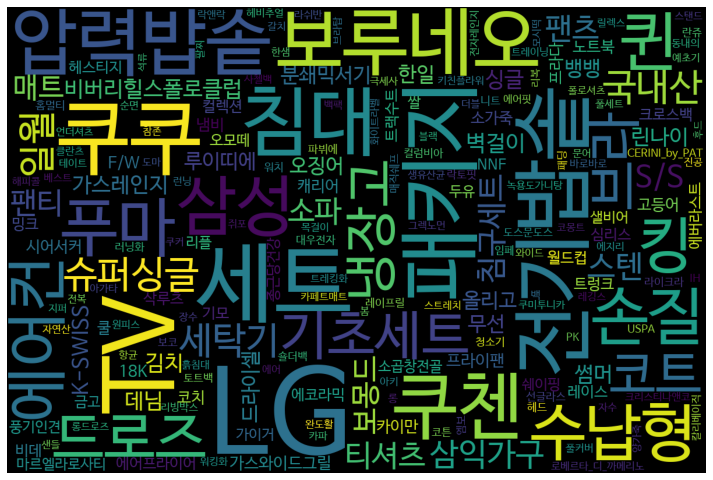

In [ ]:
from wordcloud import WordCloud

wordcloud = WordCloud(max_font_size=200, font_path= fontpath,
                     width=1200,height=800).generate_from_frequencies(word_count)
plt.figure(figsize=(10,8))
plt.imshow(wordcloud)
plt.tight_layout(pad=0)
plt.axis('off')
plt.show()

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer
vect = CountVectorizer(max_features = 200)
vect.fit(words)

CountVectorizer(analyzer='word', binary=False, decode_error='strict',
                dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
                lowercase=True, max_df=1.0, max_features=200, min_df=1,
                ngram_range=(1, 1), preprocessor=None, stop_words=None,
                strip_accents=None, token_pattern='(?u)\\b\\w\\w+\\b',
                tokenizer=None, vocabulary=None)

In [ ]:
df = pd.DataFrame(np.stack(data.상품명.map(lambda x: vect.transform(x.split()).toarray().sum(axis=0)).values),
                  columns=vect.get_feature_names(),
                  index = data.index)
df = pd.concat([data, df], axis=1)

In [ ]:
#df = df.drop(columns = ['CV'])
df = df.drop(columns = ['세일','원플원','상품명'])
df.head()

,노출(분),상품군,판매단가,취급액,판매수량,결제유형,성별,18k,cerini_by_pat,ih,lg,nnf,pk,set,swiss,tv,uspa,가스레인지,가스와이드그릴,가이거,갈치,고등어,국내산,그렉노먼,극세사,금고,기능성,기모,기초세트,김치,냄비,냉장고,노트북,녹용도가니탕,뉴스파,니트,대동모피,대우전자,더블,데님,...,쿠미투니카,쿠첸,쿠커,쿠쿠,크로스백,크리스티나앤코,클란츠,키친플라워,테이트,토트백,트랙수트,트렁크,트레이닝,트레킹화,티셔츠,파뷔에,팔찌,패딩,패키지,팬츠,팬티,폴로셔츠,푸마,풀세트,풀커버,풍기인견,프라다,프라이팬,프리미엄,한샘,한일,항균,해피콜,헤드,헤비추얼,헤스티지,홈멀티,화이트라벨,후드,흙침대
방송일시,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2019-01-01 06:00:00,20.0,의류,39900,2099000.0,52.606516,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2019-01-01 06:00:00,20.0,의류,39900,4371000.0,109.548872,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2019-01-01 06:20:00,20.0,의류,39900,3262000.0,81.754386,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2019-01-01 06:20:00,20.0,의류,39900,6955000.0,174.310777,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2019-01-01 06:40:00,20.0,의류,39900,6672000.0,167.218045,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
